In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
from os.path import expanduser

# from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
# %pip install -U GPy
import GPy

# from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import xarray as xr

# import torch
# import torch.distributions as dist
# import torch.nn as nn
# import torch.nn.functional as F
# torch.pi = torch.tensor(np.pi)

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# device = torch.device("cuda")
%matplotlib widget

In [2]:
region = "la_or_ve"
data = xr.load_dataset(expanduser(f"~/aqmsp/projects/better_interpol/data/purpleair/{region}/data.nc"))
data

<xarray.Dataset>
Dimensions:      (time: 9417, station: 1046)
Coordinates:
  * time     (time) time64[ns] 2021-06-01 ... 2022-06-30T23:00:00
  * station  (station) object '61982' '62064' ... '351628' '351634'
    lat          (station) float64 34.02 33.84 34.07 ... 33.81 33.75 33.83
    lon          (station) float64 -118.5 -118.3 -118.2 ... -118.3 -118.3
Data variables:
    value        (time, station) float64 10.12 nan 48.81 ... 12.73 14.1

In [3]:
n_timestamps = 1

for fold_id in range(5):
    print(f"Fold {fold_id}")
    test_locs = np.load(expanduser(f"~/aqmsp/projects/better_interpol/data/purpleair/{region}/test_{fold_id}.npy"))
    train_locs = np.load(expanduser(f"~/aqmsp/projects/better_interpol/data/purpleair/{region}/train_{fold_id}.npy"))
    
    train_data = data.sel(station=train_locs)
    test_data = data.sel(station=test_locs)
    train_df_per_ts = train_data.isel(time=0).to_dataframe()
    test_df_per_ts = test_data.isel(time=0).to_dataframe()
    train_X = train_df_per_ts[["lat", "lon"]].values
    test_X = test_df_per_ts[["lat", "lon"]].values
    
    # scaling
    x_min = np.array([data.lat.min().item(), data.lon.min().item()]).reshape(1, 2)
    x_max = np.array([data.lat.max().item(), data.lon.max().item()]).reshape(1, 2)
    y_mean = train_data.value.mean().item()
    y_std = train_data.value.std().item()
    
    train_X = (train_X - x_min) / (x_max - x_min)
    test_X = (test_X - x_min) / (x_max - x_min)
    train_data["value"] = (train_data["value"] - y_mean) / y_std
    break

Fold 0


In [5]:
lengthscales = []
for i in tqdm(range(6)):
    all_vals = train_data["value"].values
    null_idx = np.isnan(all_vals[i])
    X = train_X[~null_idx]
    y = all_vals[i][~null_idx]

    model = GPy.models.GPRegression(X, y.reshape(-1, 1), GPy.kern.RBF(2, ARD=True))
    model.optimize_restarts(10, verbose=False, parallel=True, num_processes=10)
    lengthscales.append(model.kern.lengthscale.values)
    # print(model)
    # model.kern.lengthscale
    # model.plot()

  0%|          | 0/6 [00:00<?, ?it/s]

 /home/patel_zeel/miniconda3/envs/gpy/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /home/patel_zeel/miniconda3/envs/gpy/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


(0.0, 100.0)

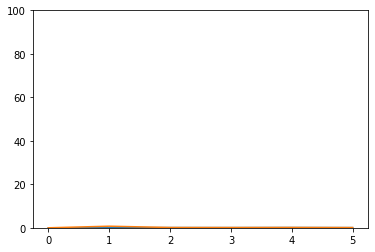

In [6]:
plt.plot(np.array(lengthscales)[:, 0])
plt.plot(np.array(lengthscales)[:, 1])

plt.ylim(0, 100)

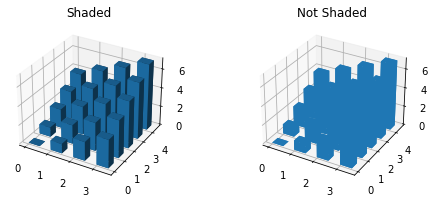

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# set up the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 0.5

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
ax2.set_title('Not Shaded')

plt.show()

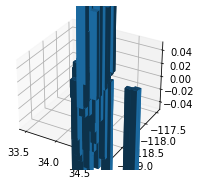

In [46]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111, projection='3d')

tmp_df = train_data.isel(time=0).to_dataframe()

ax.bar3d(tmp_df["lat"], tmp_df["lon"], np.zeros_like(tmp_df["lat"]), 0.1, 0.1, tmp_df["value"], shade=True)

In [47]:
tmp_df

,time,value,lat,lon
station,,,,
62194,2021-06-01,0.883407,34.068460,-118.206390
62203,2021-06-01,-0.038925,33.863010,-118.388960
62406,2021-06-01,0.014108,34.021534,-117.909910
62431,2021-06-01,-0.179421,33.760327,-118.088425
62434,2021-06-01,-0.140205,33.765550,-118.078640
...,...,...,...,...
303747,2021-06-01,NaN,34.358826,-119.315445
303907,2021-06-01,NaN,34.017113,-118.499460
308009,2021-06-01,NaN,33.825176,-118.318420


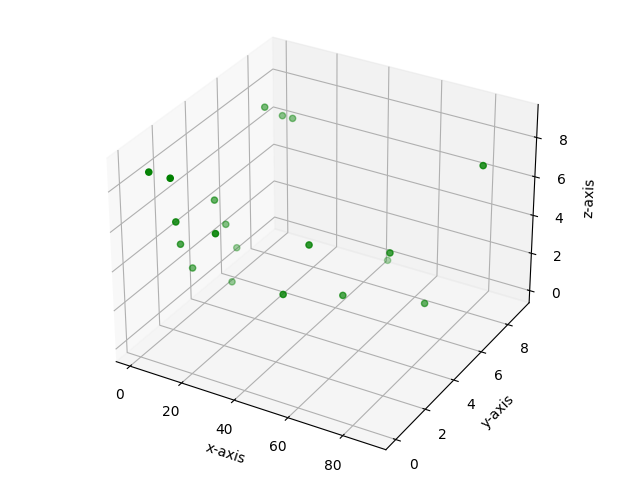

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2.4000000953674316, 'type': 'set_device_pixel_ratio'}


In [8]:
# creating 3d plot using matplotlib 
# in python
  
# for creating a responsive plot
# use %matplotlib widget in VSCODE
%matplotlib widget
# %matplotlib notebook
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
  
# creating random dataset
xs = [14, 24, 43, 47, 54, 66, 74, 89, 12,
      44, 1, 2, 3, 4, 5, 9, 8, 7, 6, 5]
  
ys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 3,
      5, 2, 4, 1, 8, 7, 0, 5]
  
zs = [9, 6, 3, 5, 2, 4, 1, 8, 7, 0, 1, 2, 
      3, 4, 5, 6, 7, 8, 9, 0]
  
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plot_geeks = ax.scatter(xs, ys, zs, color='green')
  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()